In [3]:
#Reading in the data
import os
import scipy as sp
import matplotlib.pyplot as plt
#data_dir = os.path.join(
#    os.path.dirname(os.path.realpath('__file__')), "..", "data")
data = sp.genfromtxt("../data/web_traffic.tsv",delimiter="\t")

In [4]:
# all examples will have three classes in this file
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']

In [5]:
print(data[:10])

[[1.00000000e+00 2.27333118e+03]
 [2.00000000e+00 1.65725543e+03]
 [3.00000000e+00 1.38743304e+03]
 [4.00000000e+00 1.36684635e+03]
 [5.00000000e+00 1.48923437e+03]
 [6.00000000e+00 1.33802007e+03]
 [7.00000000e+00 1.88464734e+03]
 [8.00000000e+00 2.28475432e+03]
 [9.00000000e+00 1.33581092e+03]
 [1.00000000e+01 1.02583237e+03]]


In [6]:
print(data.shape)

(743, 2)


In [7]:
# preprocessing and Cleaning the data
x = data[:, 0]
y = data[:, 1]
print("Number of invalid entries:", sp.sum(sp.isnan(y)))
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

Number of invalid entries: 0


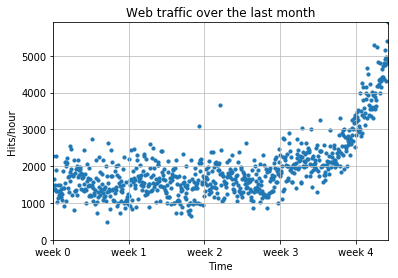

In [8]:
# plot input data
def plot_models(x, y, models, fname, mx=None, ymax=None, xmin=None):
    plt.clf()
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    plt.savefig(fname)

# first look at the data
plot_models(x, y, None, os.path.join("../output", "1400_01_01.png"))

Model parameters: [   2.57155566 1003.16451154]
Error of the model: [3.20035168e+08]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


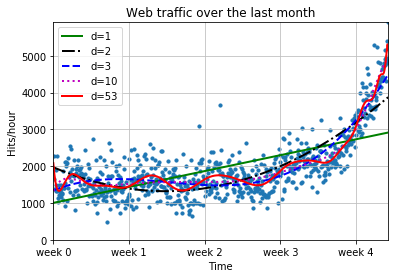

In [9]:
os.path.join("../output", "1400_01_01.png")

# create and plot models
fp1, res, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)
print("Model parameters: %s" % fp1)
print("Error of the model:", res)
f1 = sp.poly1d(fp1)
f2 = sp.poly1d(sp.polyfit(x, y, 2))
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))
f100 = sp.poly1d(sp.polyfit(x, y, 100))

plot_models(x, y, [f1], os.path.join("../output", "1400_01_02.png"))
plot_models(x, y, [f1, f2], os.path.join(".", "1400_01_03.png"))
plot_models(
    x, y, [f1, f2, f3, f10, f100], os.path.join("../output", "1400_01_04.png"))

588.0


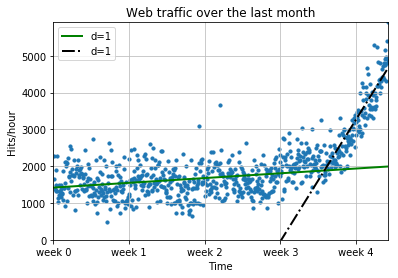

In [10]:
# fit and plot a model using the knowledge about inflection point
inflection = 3.5 * 7 * 24
print(inflection)
x = data[:, 0]
y = data[:, 1]
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]
#print(x)
#print(y)
#注意，这里直接用inflection 会报错
xa = x[:588]
ya = y[:588]
xb = x[588:]
yb = y[588:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

plot_models(x, y, [fa, fb], os.path.join("../output", "1400_01_05.png"))

Errors for the complete data set:
Error d=1: 320035167.628450
Error d=2: 182097765.510349
Error d=3: 140749054.041900
Error d=10: 123641832.680265
Error d=53: 111264794.006046
Errors for only the time after inflection point
Error d=1: 147743285.569134
Error d=2: 63399512.433742
Error d=3: 34699900.658532
Error d=10: 23121099.595491
Error d=53: 20386065.500399
Error inflection=136543685.925772


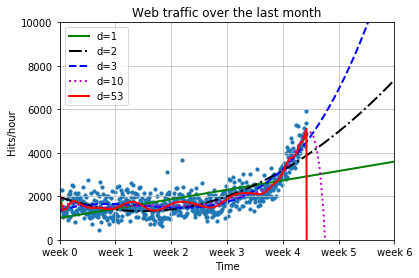

In [11]:
def error(f, x, y):
    return sp.sum((f(x) - y) ** 2)

print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, x, y)))

print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

print("Error inflection=%f" % (error(fa, xa, ya) + error(fb, xb, yb)))
# extrapolating into the future
plot_models(
    x, y, [f1, f2, f3, f10, f100], os.path.join("../output", "1400_01_06.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

Trained only on data after inflection point
Errors for only the time after inflection point
Error d=1: 26974039.846994
Error d=2: 21981595.608146
Error d=3: 21801586.363884
Error d=10: 20597149.999306
Error d=53: 19581005.913305


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


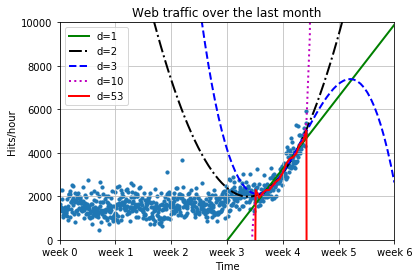

In [12]:
print("Trained only on data after inflection point")
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))

print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100], os.path.join("../output", "1400_01_07.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Test errors for only the time after inflection point
Error d=1: 6000740.944219
Error d=2: 5922824.918266
Error d=3: 6341042.863675
Error d=10: 6566189.265449
Error d=53: 6709403.007788


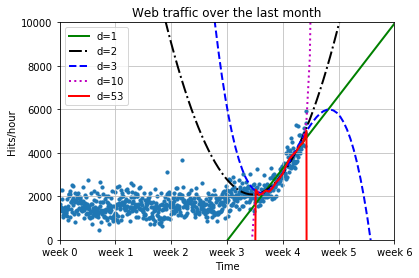

In [13]:
# separating training from testing data
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = sp.random.permutation(list(range(len(xb))))
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])
fbt1 = sp.poly1d(sp.polyfit(xb[train], yb[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))
fbt3 = sp.poly1d(sp.polyfit(xb[train], yb[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb[train], yb[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb[train], yb[train], 100))

print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))

plot_models(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100], os.path.join("../output",
                                                          "1400_01_08.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

In [14]:
from scipy.optimize import fsolve
print(fbt2)
print(fbt2 - 100000)
reached_max = fsolve(fbt2 - 100000, 800) / (7 * 24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

       2
0.116 x - 134.8 x + 4.125e+04
       2
0.116 x - 134.8 x - 5.875e+04
100,000 hits/hour expected at week 8.925655


1456118.9304350805 0


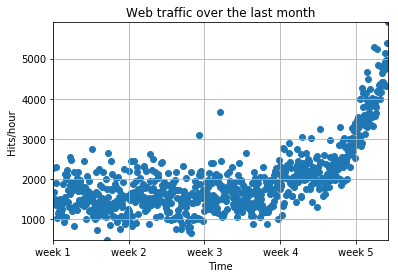

In [16]:
# This script generates web traffic data for our hypothetical
# web startup "MLASS" in chapter 01

import os
import scipy as sp
from scipy.stats import gamma
import matplotlib.pyplot as plt

sp.random.seed(3)  # to reproduce the data later on

x = sp.arange(1, 31 * 24)
# dtype=int，下一句会报错。
y = sp.array(200 * (sp.sin(2 * sp.pi * x / (7 * 24))), dtype=float)
y += gamma.rvs(15, loc=0, scale=100, size=len(x))
y += 2 * sp.exp(x / 100.0)
y = sp.ma.array(y, mask=[y < 0])
print(sum(y), sum(y < 0))

plt.scatter(x, y)
plt.title("Web traffic over the last month")
plt.xlabel("Time")
plt.ylabel("Hits/hour")
plt.xticks([w * 7 * 24 for w in [0, 1, 2, 3, 4]], ['week %i' % (w + 1) for w in [
           0, 1, 2, 3, 4]])

plt.autoscale(tight=True)
plt.grid()
plt.savefig(os.path.join("../output", "1400_01_01.png"))

# python3中 realpath('__file__')
data_dir = os.path.join(
    os.path.dirname(os.path.realpath('__file__')), "..", "data")

# sp.savetxt(os.path.join("..", "web_traffic.tsv"),
# zip(x[~y.mask],y[~y.mask]), delimiter="\t", fmt="%i")
sp.savetxt(os.path.join(
    data_dir, "web_traffic.tsv"), list(zip(x, y)), delimiter="\t", fmt="%s")